### Download libraries

In [ ]:
pip install -r requirements.txt

In [1]:
import requests

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import time
import random
from collections import Counter

from pymorphy3 import MorphAnalyzer
import nltk
import spacy
#nltk.download('punkt')
#nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score, train_test_split
from operator import itemgetter
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Set VK API methods and access_token

In [ ]:
url = "https://api.vk.com/method/groups.getMembers"
url2 = "https://api.vk.com/method/users.get"
url3 = "https://api.vk.com/method/groups.get"

access_token = "YOUR TOKEN"
p = {"access_token":access_token, "v":"5.131"}

### Extract members from the group
I choose a group dedicated to the work of Hayao Miyazaki, as I want to find out what his fans are interested in. Let's extract 2000 members.

In [3]:
def get_members(ID, how_many_members):
    members_list = []
    p["group_id"] = ID
    p["count"] = 100

    for offset in tqdm(range(0, how_many_members, 100)):
        p["offset"] = offset
        global inf
        inf = requests.get(url, params = p).json()
        time.sleep(0.24)
        for member in inf["response"]["items"]:
            members_list.append(member)

    return members_list

In [ ]:
group_id = "miyazaki_club"

members_list = get_members(group_id, 2000)
len(members_list)

### Extract groups of each member

In [23]:
def get_users_groups(members, how_many_groups):

    session = requests.Session()

    p = {"access_token":access_token, "fields":"description", "extended":1, "count":how_many_groups}
    id_of_group = []
    name_of_group = []
    description_of_group = []
    versions = ["5.199", "5.195", "5.194", "5.154", "5.141", "5.139"]

    for user_groups in tqdm(members):
        p["user_id"] = user_groups
        p["v"] = random.choice(versions)
        inf = session.get(url3, params = p).json()
        #time.sleep(0.05)

        if "response" in inf:
            for num_group in range(0, inf["response"]["count"], 1):
                try:
                    id_of_group.append(inf["response"]["items"][num_group]["id"])
                except:
                    id_of_group.append("-")
                try:
                    name_of_group.append(inf["response"]["items"][num_group]["name"])
                except:
                    name_of_group.append("-")
                try:
                    description_of_group.append(inf["response"]["items"][num_group]["description"])
                except:
                    description_of_group.append("-")


    df_of_groups = pd.DataFrame(list(zip(id_of_group, name_of_group, description_of_group)),
                                       columns = ["ID", "Name of Group", "Description of Group"])

    df_of_groups = df_of_groups.loc[df_of_groups["ID"] != "-"].reset_index(drop = True)

    return df_of_groups

In [ ]:
df_of_groups = get_users_groups(members_list, 20)
df_of_groups

### Text Preprocessing

In [25]:
group_description = df_of_groups["Description of Group"]
morph = MorphAnalyzer()
pos_list = ["NOUN", "ADJF", "COMP", "ADJS", "VERB", "INFN", "PRTF", "PRTS", "ADVB"] # list with parts of speech

stop_words_spacy = list(spacy.load('ru_core_news_sm').Defaults.stop_words)
stop_words_nltk = nltk.corpus.stopwords.words('russian')
russian_stop_words = set(stop_words_spacy + stop_words_nltk)
russian_stop_words.update({'группа', 'сообщество', 'паблик', 'то', 'что'})

def preprocess_text(group_description: list[str], exclude_stop_words: bool=True):
    tokenized_text = []
    lemmatized_text = []

    for x in group_description:
        tokenized_text.append(nltk.word_tokenize(x))

    if exclude_stop_words:

        for text in tqdm(tokenized_text):
            text_tokens = []
            for token in text:
                token_morph = morph.parse(token)[0] # [0] - most likely description of the word
                if token_morph.tag.POS in pos_list and token_morph.normal_form not in russian_stop_words and token not in russian_stop_words:
                    text_tokens.append(token_morph.normal_form)
            lemmatized_text.append(text_tokens)

    else:

        for text in tqdm(tokenized_text):
            text_tokens = []
            for token in text:
                token_morph = morph.parse(token)[0]
                if token_morph.tag.POS in pos_list:
                    text_tokens.append(token_morph.normal_form)
            lemmatized_text.append(text_tokens)

    return lemmatized_text


def bag_of_words(text):
    all_tokens = []

    for lemm_list in tqdm(text):
        for word in lemm_list:
            all_tokens.append(word)

    return pd.DataFrame(dict(Counter(all_tokens)).items(), columns=["Token", "Frequency"])\
                        .sort_values(by="Frequency", ascending=False).reset_index(drop=True)


def joined_bag(text):
    text_for_vektors = []

    for t in tqdm(text):
        joined_lemmas = []
        if len(t) > 1:
            joined_lemmas.append(" ".join(t))
        text_for_vektors.append(" ".join(joined_lemmas))

    return text_for_vektors

In [ ]:
lemmatized_text = preprocess_text(group_description)
bag = bag_of_words(lemmatized_text)
j_bag = joined_bag(lemmatized_text)

In [27]:
bag.head(30)

,Token,Frequency
0,новость,2633
1,мир,2450
2,год,2268
3,человек,2249
4,жизнь,1891
5,интересный,1837
6,хороший,1799
7,новый,1775
8,работа,1769
9,найти,1703


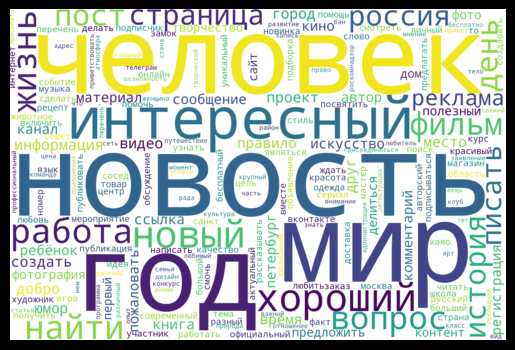

In [28]:
word_cloud = WordCloud(collocations = False, background_color = 'white',
                       width = 2160, height = 1440).generate(str(j_bag))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Clustering with LDA

In [41]:
# Clustering tokens
tfidf = TfidfVectorizer(max_features=1000)
x = tfidf.fit_transform(j_bag)
cluster_num = 16
lda = LatentDirichletAllocation(n_components=cluster_num,
                                learning_method="batch",
                                max_iter=300,
                                random_state=0,
                                n_jobs=-1)

document_topics = lda.fit_transform(x)

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(list(dict(sorted(tfidf.vocabulary_.items(), key=itemgetter(1))).keys()))
clusters_tokens = []
for num in range(0, cluster_num):
    tokens_list = list(feature_names[list(sorting[num])])
    clusters_tokens.append(tokens_list)

df_clust = pd.DataFrame(clusters_tokens).T
#pd.DataFrame(document_topics)

In [42]:
df_clust.head(25)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,история,номер,музыка,новость,фильм,перечень,животное,искусство,рецепт,заказ,идея,замок,юмор,реклама,россия,год
1,душа,регистрация,человек,пост,кино,страница,собака,жизнь,вкусный,магазин,дизайн,хаяо,хороший,книга,петербург,ребёнок
2,место,мем,мир,предложить,сериал,канал,котик,вдохновение,комикс,доставка,интерьер,сосед,сарказм,новость,город,человек
3,мода,заявление,песня,правило,новинка,рубрика,кошка,мир,готовить,товар,совет,миядзак,свежий,мир,санкт,школа
4,красота,сотрудничество,творческий,писать,смотреть,роскомнадзор,природа,добро,подписаться,украшение,ремонт,призрак,новость,выгодный,мероприятие,проект
5,вместе,заявка,история,вопрос,подборка,телеграм,удивительный,то,рекомендовать,одежда,английский,панда,жизнь,интересный,москва,курс
6,шоу,подписываться,слово,комментарий,просмотр,официальный,планета,пожаловать,иллюстрация,работа,полезный,унести,фильм,вконтакте,современный,работа
7,ежедневный,реклама,простой,реклама,хороший,включить,мир,что,кулинарный,сообщение,дом,любитель,день,журнал,официальный,индивидуальный
8,уход,психология,рок,сообщение,художник,регистрация,наука,смысл,вкус,россия,язык,ходячий,шутка,главное,концерт,обучение
9,маникюр,человек,рассказывать,публикация,приложение,персональный,кот,красота,связать,изделие,татуировка,тоторо,ирония,вкусный,год,жизнь


Looks like there are 7 clusters that signal the interests of Miyazaki's audience:
- cluster "2" focuses on the music and creativity; 
- seems like cluster "4" is about cinema;
- cluster "6" is about pets;
- cluster "7" is a bit originative;
- cluster "8" focused on food, cuisine and diet;
- cluster "14" talks about leisure and city events;
- cluster "15" clearly about education and growth.

### Сalculating presence of each cluster

In [43]:
# Classification on clusters
clusters_imp = [2, 4, 6, 7, 8, 14, 15] # Important clusters

cluster_solution = []
for mark_list in document_topics:
    cluster_solution.append(mark_list[clusters_imp])

y = []
for marks_lists in cluster_solution:
    m = list(marks_lists)
    y.append(m.index(max(m)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

classifier = LogisticRegression(max_iter=300)

classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
cross_validation = cross_val_score(classifier, x, y, cv=5)

print("Train data:", round(classifier.score(x_train, y_train), 3))
print("Test data:", round(classifier.score(x_test, y_test), 3))
print("\n", classification_report(y_test, y_pred))
print("Cross validation:", cross_validation, "≈", round(cross_validation.mean(), 3))

scores = classifier.predict_proba(x.toarray())
df_list = []
index = 0
for t in x:
    df_list.append(list(np.append(t, scores[index])))
    index += 1

Train data: 0.871
Test data: 0.826

               precision    recall  f1-score   support

           0       0.80      0.92      0.86       725
           1       0.84      0.75      0.80       325
           2       0.93      0.70      0.80       273
           3       0.83      0.86      0.85       524
           4       0.84      0.80      0.82       353
           5       0.81      0.80      0.81       487
           6       0.81      0.81      0.81       641

    accuracy                           0.83      3328
   macro avg       0.84      0.81      0.82      3328
weighted avg       0.83      0.83      0.82      3328

Cross validation: [0.81550481 0.8188101  0.82542067 0.82271635 0.81280048] ≈ 0.819


In [44]:
clusters_probs = pd.DataFrame(df_list).iloc[:, -len(clusters_imp):]\
                                      .set_axis(["Cluster_" + str(i) for i in clusters_imp], axis=1)

clusters_presence = clusters_probs.sum()

# Color scheme
bg_color = "#2D2A26"
paper_bg = "#2D2A26"
font_color = "#D9CAB3"

labels = clusters_presence.index.tolist()
values = clusters_presence.values.tolist()

# For hover: join top-5 words 
hover_text = []
for lab in labels:
    idx = int(lab.split("_")[1])
    top5 = clusters_tokens[idx][:5]
    hover_text.append(", ".join(top5))

# Pie
fig = go.Figure(go.Pie(
    labels=labels,
    values=values,
    textinfo='percent',
    hoverinfo='label+percent+text',
    hovertext=hover_text,
    marker=dict(colors=px.colors.qualitative.Pastel)  
))

fig.update_layout(
    title=f'Tematic Clusters for {group_id} group',
    plot_bgcolor=bg_color,
    paper_bgcolor=paper_bg,
    font=dict(color=font_color),
    legend=dict(font=dict(color=font_color)),
    width=1000
)

fig.show()

Now we have probable distribution of the interests of Hayao Miyazaki's fans. It seems that they spend a lot of time reading and they generally care about art and the world around them.